In [16]:
import cython
import numpy as np
import sys
print(sys.path)
import CyRK
print(CyRK.__version__)
from numba import cfunc

['N:\\Joe Documents\\Work Documents\\Software\\CyRK\\Tests', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\python311.zip', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\DLLs', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311', '', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\win32', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\Pythonwin']
0.10.0a3.dev16


In [18]:
dir(cfunc)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getstate__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [13]:
def diffeq(dy, t, y):
    dy[0] = -y[1]
    dy[1] = y[0]
    
diffeq_c = cfunc("void(float64[::1], float64, float64[::1])")(diffeq)

In [7]:
dy = np.empty(2, dtype=np.float64, order='C')
y = np.asarray((20., 10.), dtype=np.float64, order='C')

diffeq(dy, 10., y)
print(dy)

dy = np.empty(2, dtype=np.float64, order='C')

diffeq_c(dy, 10., y)
print(dy)

[-10.  20.]
[-10.  20.]


In [8]:
%timeit diffeq(dy, 10., y)

543 ns ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%timeit diffeq_c(dy, 10., y)

1 µs ± 9.03 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [14]:
diffeq_c.ctypes

TypeError: Cannot convert Numba type 'array(float64, 1d, C)' to ctypes type

In [ ]:
t_start = 0.0
t_end = 50.0
y0 = np.asarray((20.0, 20.0), dtype=np.float64, order='C')

def diffeq(t, y):
    print("HEL")
    y0 = y[0]
    y1 = y[1]
    return np.asarray([(1. - 0.01 * y1) * y0, (0.02 * y0 - 1.) * y1])

result = pysolve_ivp(
        diffeq,
        (t_start, t_end),
        y0,
        method = 'RK45',
        rtol = 1.0e-7,
        atol = 1.0e-8
        )

In [2]:
%load_ext cython

In [12]:
%%cython --annotate --force --compile-args=/openmp --link-args=/openmp -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libc.string cimport memcpy
from libcpp cimport nullptr
from libcpp cimport bool as cpp_bool
from libcpp.cmath cimport fmin, fabs

cimport cpython.ref as cpy_ref
from CyRK.utils.vector cimport vector
from CyRK.utils.memory cimport shared_ptr, make_shared
from CyRK.cy.cysolverNew cimport (INF, EPS_100,Y_LIMIT, DY_LIMIT, MAX_STEP, DiffeqFuncType, find_expected_size, CySolverResult,
                                 CySolverBase,RKSolver,RK23, RK45, DOP853, baseline_cysolve_ivp, PySolverStatePointers, PySolver)


    
import numpy as np
cimport numpy as cnp

# =====================================================================================================================
# Import CySolverResult (container for integration results)
# =====================================================================================================================
cdef class WrapCySolverResult:
    cdef shared_ptr[CySolverResult] cyresult_shptr
    cdef CySolverResult* cyresult_ptr
    cdef double* time_ptr
    cdef double* y_ptr
    cdef double[::1] time_view
    cdef double[::1] y_view

    cdef size_t size
    cdef size_t num_dy
    
    cdef void set_cyresult_pointer(self, shared_ptr[CySolverResult] cyresult_shptr):

        # Store c++ based result and pull out key information
        self.cyresult_shptr = cyresult_shptr
        self.cyresult_ptr   = cyresult_shptr.get()
        self.size           = self.cyresult_ptr[0].size
        self.num_dy         = self.cyresult_ptr[0].num_dy

        # Convert solution to pointers and views
        self.time_ptr  = &self.cyresult_ptr[0].time_domain[0]
        self.y_ptr     = &self.cyresult_ptr[0].solution[0]
        self.time_view = <double[:self.size]>self.time_ptr
        self.y_view    = <double[:self.size * self.num_dy]>self.y_ptr

    @property
    def success(self):
        return self.cyresult_ptr.success
        
    @property
    def message(self):
        return str(self.cyresult_ptr.message_ptr, 'UTF-8')
    
    @property
    def t(self):
        return np.asarray(self.time_view, dtype=np.float64, order='C')
    
    @property
    def y(self):
        return np.asarray(self.y_view, dtype=np.float64, order='C').reshape((self.size, self.num_dy)).T
    
    @property
    def size(self):
        return self.size

# =====================================================================================================================
# Create Wrapped cysolve_ivp (has various defaults)
# =====================================================================================================================

cdef shared_ptr[CySolverResult] cysolve_ivp(
            DiffeqFuncType diffeq_ptr,
            double* t_span_ptr,
            double* y0_ptr,
            size_t num_y,
            int method = 1,
            size_t expected_size = 0,
            size_t num_extra = 0,
            double* args_ptr = NULL,
            size_t max_num_steps = 0,
            size_t max_ram_MB = 2000,
            double rtol = 1.0e-3,
            double atol = 1.0e-6,
            double* rtols_ptr = NULL,
            double* atols_ptr = NULL,
            double max_step_size = MAX_STEP,
            double first_step_size = 0.0
            ) noexcept nogil:

    return baseline_cysolve_ivp(
        diffeq_ptr,
        t_span_ptr,
        y0_ptr,
        num_y,
        method,
        expected_size,
        num_extra,
        args_ptr,
        max_num_steps,
        max_ram_MB,
        rtol,
        atol,
        rtols_ptr,
        atols_ptr,
        max_step_size,
        first_step_size
        )

# =====================================================================================================================
# PySolver Class (holds the intergrator class and reference to the python diffeq function)
# =====================================================================================================================
cdef class WrapPyDiffeq:
    

    cdef object diffeq_func
    cdef tuple args
    cdef cpp_bool use_args
    cdef cpp_bool pass_dy_as_arg

    cdef unsigned int num_y
    cdef unsigned int num_dy

    cdef cnp.ndarray y_now_arr
    cdef double[::1] y_now_view
    cdef double* y_now_mem_ptr
    cdef cnp.ndarray dy_now_arr
    cdef double[::1] dy_now_view
    cdef double* dy_now_mem_ptr
    

    # State attributes
    cdef double* y_now_ptr
    cdef double* t_now_ptr
    cdef double* dy_now_ptr

    def __cinit__(
            self,
            object diffeq_func,
            tuple args,
            unsigned int num_y,
            unsigned int num_dy,
            bint pass_dy_as_arg = False
            ):
        
        # Install differential equation function and any additional args
        self.diffeq_func = diffeq_func
        if args is None:
            self.args = None
            self.use_args = False
        else:
            self.args = args
            self.use_args = True
        
        # Build python-safe arrays
        self.num_y  = num_y
        self.num_dy = num_dy
        self.y_now_arr   = np.empty(self.num_y, dtype=np.float64, order='C')
        self.y_now_view  = self.y_now_arr
        self.y_now_mem_ptr = &self.y_now_view[0]

        if pass_dy_as_arg:
            self.pass_dy_as_arg = True
            self.dy_now_arr = np.empty(self.num_dy, dtype=np.float64, order='C')
            self.dy_now_view = self.dy_now_arr
            self.dy_now_mem_ptr = &self.dy_now_view[0]
        else:
            self.pass_dy_as_arg = False
    
    cdef void set_state(self, double* dy_ptr, double* t_ptr, double* y_ptr) noexcept nogil:
        self.dy_now_ptr = dy_ptr
        self.t_now_ptr  = t_ptr
        self.y_now_ptr  = y_ptr

    def diffeq(self):
        # Copy over pointer values to python-safe arrays
        cdef unsigned int y_i
        memcpy(self.y_now_mem_ptr, self.y_now_ptr, sizeof(double) * self.num_y)
        for y_i in range(self.num_y):
            self.y_now_view[y_i] = self.y_now_ptr[y_i]
        
        # Run python diffeq
        if self.pass_dy_as_arg:
            if self.use_args:
                self.diffeq_func(self.dy_now_arr, self.t_now_ptr[0], self.y_now_arr, *self.args)
            else:
                self.diffeq_func(self.dy_now_arr, self.t_now_ptr[0], self.y_now_arr)
        else:
            if self.use_args:
                self.dy_now_view = self.diffeq_func(self.t_now_ptr[0], self.y_now_arr, *self.args)
            else:
                self.dy_now_view = self.diffeq_func(self.t_now_ptr[0], self.y_now_arr)
        
        # Store results in dy pointer for the integrator
        # Note that num_dy may be larger than num_y if the user is capturing extra output during integration.
        memcpy(self.dy_now_ptr, self.dy_now_mem_ptr, sizeof(double) * self.num_dy)

        return 1

# =====================================================================================================================
# PySolver wrapper function
# =====================================================================================================================

def pysolve_ivp(
        object py_diffeq,
        tuple time_span,
        double[::1] y0,
        str method = 'RK45',
        double[::1] t_eval = None,
        bint dense_output = False,
        tuple args = None,
        unsigned int expected_size = 0,
        unsigned int num_extra = 0,
        double first_step = 0.0,
        double max_step = INF,
        rtol = 1.0e-3,
        atol = 1.0e-6,
        size_t max_num_steps = 0,
        size_t max_ram_MB = 2000
        ):

    # Parse method
    method = method.lower()
    cdef unsigned int integration_method = 1
    if method == "rk23":
        integration_method = 0
    elif method == "rk45":
        integration_method = 1
    elif method == 'dop853':
        integration_method = 2
    else:
        raise NotImplementedError(
            f"Unknown or unsupported integration method provided: {method}.\n"
            f"Supported methods are: RK23, RK45, DOP853."
            )
    
    # Parse time_span
    cdef double t_start = time_span[0]
    cdef double t_end   = time_span[1]

    # Parse y0
    cdef unsigned int num_y = len(y0)
    cdef double* y0_ptr     = &y0[0]
    if num_y > Y_LIMIT:
        raise AttributeError(
            f"CyRK only supports a maximum number of {Y_LIMIT} dependent variables. {num_y} were provided."
            )
    
    # Parse t_eval
    if t_eval is not None:
        raise NotImplementedError('t_eval not implemented.')
    
    # Parse dense output
    if dense_output:
        raise NotImplementedError('Dense outputs not yet supported.')
    
    # Parse num_extra
    if num_extra > (DY_LIMIT - Y_LIMIT):
        raise AttributeError(
            f"CyRK can only capture a maximum number of {DY_LIMIT - Y_LIMIT} extra outputs. {num_extra} were provided."
            )
    cdef unsigned int num_dy = num_y + num_extra
    
    # Parse rtol
    cdef double* rtols_ptr = NULL
    cdef double[::1] rtols_view
    cdef double rtol_float = 0.0
    if type(rtol) == float:
        rtol_float = rtol
    else:
        rtols_view = np.asarray(rtol, dtype=np.float64, order='C')
        rtols_ptr = &rtols_view[0]
    
    # Parse atol
    cdef double* atols_ptr = NULL
    cdef double[::1] atols_view
    cdef double atol_float = 0.0
    if type(atol) == float:
        atol_float = atol
    else:
        atols_view = np.asarray(atol, dtype=np.float64, order='C')
        atols_ptr = &atols_view[0]
    
    # Parse expected size
    cdef double expected_size_touse = expected_size
    cdef double rtol_tmp
    cdef double min_rtol = INF
    if expected_size_touse == 0:
        if rtols_ptr:
            # rtol for each y
            for y_i in range(num_y):
                rtol_tmp = rtols_ptr[y_i]
                if rtol_tmp < EPS_100:
                    rtol_tmp = EPS_100
                min_rtol = fmin(min_rtol, rtol_tmp)
        else:
            # Only one rtol
            rtol_tmp = rtol
            if rtol_tmp < EPS_100:
                rtol_tmp = EPS_100
            min_rtol = rtol_tmp
        expected_size_touse = find_expected_size(num_y, num_extra, fabs(t_end - t_start), min_rtol)

    # Build solution storage
    cdef shared_ptr[CySolverResult] result_ptr = make_shared[CySolverResult](num_y, num_extra, expected_size)

    # Build diffeq wrapper
    cdef WrapPyDiffeq diffeq_wrap = WrapPyDiffeq(py_diffeq, args, num_y, num_dy)


    # Finally we can actually run the integrator!
    # The following effectively copies the functionality of cysolve_ivp. We can not directly use that function
    # because we need to tie in the python-based diffeq function (via its wrapper)
    
    # Build null pointers to unused arguments
    cdef double* args_ptr = NULL

    # We need to heap allocate the PySolver class instance otherwise it can get garbage collected while the solver
    # is running.
    cdef PySolver* solver = new PySolver(
            integration_method,
            <cpy_ref.PyObject*>diffeq_wrap,
            result_ptr,
            t_start,
            t_end,
            y0_ptr,
            num_y,
            num_extra,
            args_ptr,
            max_num_steps,
            max_ram_MB,
            rtol_float,
            atol_float,
            rtols_ptr,
            atols_ptr,
            max_step,
            first_step
        )

    # Get pointers to the solver's state variables so that the Python differential equation can use and update them.
    cdef PySolverStatePointers state_pointers = solver.get_state_pointers()
    diffeq_wrap.set_state(
        state_pointers.dy_now_ptr,
        state_pointers.t_now_ptr,
        state_pointers.y_now_ptr
        )
    
    ##
    # Run the integrator!
    ##
    solver.solve()
    
    # Wrap the solution in a python-safe wrapper class
    cdef WrapCySolverResult pyresult = WrapCySolverResult()
    pyresult.set_cyresult_pointer(result_ptr)

    del solver

    return pyresult


Content of stdout:
_cython_magic_16ca19a42e752fff44812efeeb17aa70058a59b0.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_16ca19a42e752fff44812efeeb17aa70058a59b0.cpp(21356): warning C4267: 'argument': conversion from 'size_t' to 'const unsigned int', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_16ca19a42e752fff44812efeeb17aa70058a59b0.cpp(21356): warning C4267: 'argument': conversion from 'size_t' to 'const unsigned int', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_16ca19a42e752fff44812efeeb17aa70058a59b0.cpp(23258): warning C4244: '=': conversion from 'Py_ssize_t' to 'unsigned int', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_16ca19a42e752fff44812efeeb17aa70058a59b0.cpp(23868): warning C4244: '=': conv

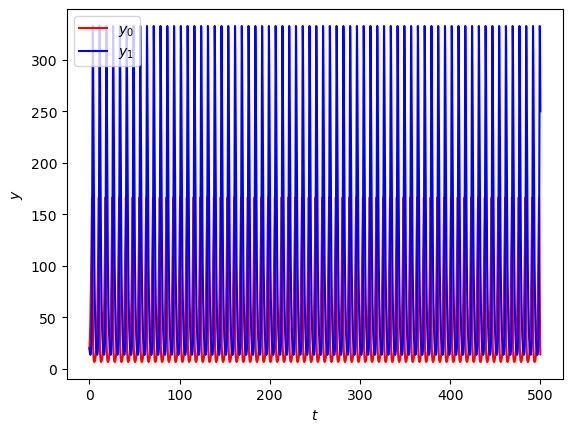

In [5]:
res = run()
diff_plot(res.t, res.y)

In [8]:
# 3.01ms; 3.08ms; 3.04ms
# Compared to pure C of 792us
%timeit run()

3.04 ms ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


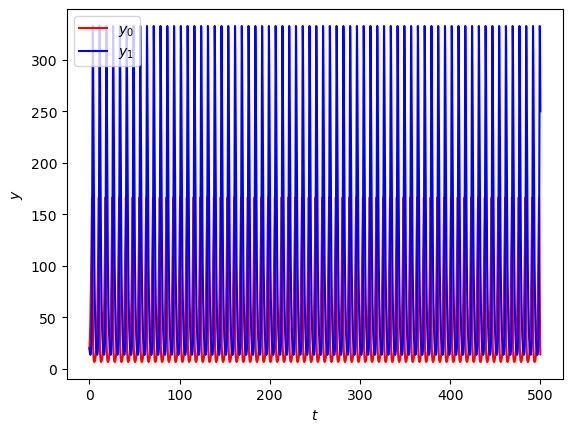

(2, 3535)


In [11]:
def diffeq(t, y):
    y0 = y[0]
    y1 = y[1]
    return [(1. - 0.01 * y1) * y0, (0.02 * y0 - 1.) * y1]

t_span = (0.0, 500.0)
rtol = 1.0e-7
atol = 1.0e-8
y0 = np.asarray((20.0, 20.0))

from scipy.integrate import solve_ivp

def run_sci():
    sol = solve_ivp(diffeq, t_span, y0, method='RK45', rtol=rtol, atol=atol)
    return sol

sol = run_sci()
diff_plot(sol.t, sol.y)
print(sol.y.shape)

In [12]:
%timeit run_sci()

407 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
